# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import *

import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense, Dropout,GlobalMaxPooling1D
#from keras.utils.np_utils import to_categorical
from keras.models import Sequential

np.random.seed(0)
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preprocessing Data**

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CIDDS-001/reduced_cidds_001_normal_portscan_pingscan.csv')
df1 = df1.rename(columns={'class': 'label'})

df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CIDDS-002/reduced_cidds_002_normal_scan.csv')

df = pd.concat([df1, df2], ignore_index=True)
df

<ipython-input-3-9348c4072206>:1: DtypeWarning: Columns (8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CIDDS-001/reduced_cidds_001_normal_portscan_pingscan.csv')
<ipython-input-3-9348c4072206>:4: DtypeWarning: Columns (8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CIDDS-002/reduced_cidds_002_normal_scan.csv')


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,label,attackType,attackID,attackDescription
0,2017-03-23 13:40:24.221,0.134,TCP,10305_148,443,192.168.210.5,50210.0,5,449,1,.AP.S.,32,normal,---,---,---
1,2017-03-22 16:15:56.404,0.000,TCP,10001_230,443,192.168.220.15,44214.0,1,462,1,.AP...,0,normal,---,---,---
2,2017-04-18 10:09:51.492,0.508,TCP,16796_188,443,192.168.200.4,42941.0,7,6203,1,.AP.S.,32,normal,---,---,---
3,2017-03-15 11:23:38.445,0.095,TCP,10068_2,443,192.168.220.8,58538.0,5,1246,1,.AP...,32,normal,---,---,---
4,2017-03-23 16:59:50.774,0.000,TCP,15306_50,80,192.168.220.13,41670.0,1,66,1,.A....,32,normal,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231831,2017-08-08 19:52:49.297,0.000,TCP,192.168.210.56,5907,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2
5231832,2017-08-08 19:52:49.296,0.000,TCP,192.168.210.56,3,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2
5231833,2017-08-08 19:52:49.296,0.000,TCP,192.168.210.56,32778,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2
5231834,2017-08-08 19:52:49.296,0.000,TCP,192.168.210.56,8800,192.168.220.51,47529.0,1,54,1,.A.R..,0,victim,scan,20,nmap args: -sS -T 2


In [4]:
df.select_dtypes(include=['object']).columns

Index(['Date first seen', 'Proto', 'Src IP Addr', 'Dst IP Addr', 'Bytes',
       'Flags', 'label', 'attackType', 'attackID', 'attackDescription'],
      dtype='object')

In [5]:
df.isna().sum()

Date first seen      0
Duration             0
Proto                0
Src IP Addr          0
Src Pt               0
Dst IP Addr          0
Dst Pt               0
Packets              0
Bytes                0
Flows                0
Flags                0
Tos                  0
label                0
attackType           0
attackID             0
attackDescription    0
dtype: int64

In [6]:
df.duplicated().sum()

36568

In [7]:
df.drop_duplicates(inplace = True)
df.shape

(5195268, 16)

In [8]:
df['Proto'].value_counts()

TCP      4386603
UDP       744306
ICMP       64206
IGMP         153
Name: Proto, dtype: int64

In [9]:
df['Bytes'].astype('str').value_counts()

      66    1236773
54           416949
58           211005
      54     160471
      55     139482
             ...   
   54222          1
   81674          1
   19389          1
   35240          1
20573             1
Name: Bytes, Length: 84192, dtype: int64

In [10]:
df['Flags'].value_counts()

.A....    1570689
......     808665
.AP...     700075
.AP.S.     550334
.A...F     386492
.A.R..     238101
....S.     225951
.AP..F     170048
.A..S.     142218
.AP.SF     136838
.....F     112958
...R..      58520
.APRSF      34740
.APR.F      32791
.A..SF       6646
...RS.       6176
.A.R.F       5660
.APRS.       4334
.APR..       3703
.A.RS.        230
.A.RSF         99
Name: Flags, dtype: int64

In [11]:
df['label'].value_counts()

normal      4378392
attacker     511295
victim       305581
Name: label, dtype: int64

In [12]:
df['attackType'].value_counts()

---         4378392
scan         534561
portScan     276234
pingScan       6081
Name: attackType, dtype: int64

In [13]:
df['attackID'].value_counts()

---    4378392
11       54703
17       53283
20       46916
32       43312
        ...   
57         522
58         509
65         371
66         359
69         359
Name: attackID, Length: 68, dtype: int64

In [14]:
df['attackDescription'].value_counts()

---                           4382402
nmap args: -sS -T 2            185630
nmap args: -sF -T 3            109847
nmap args: -sS -T 1            107124
nmap args: -sS -T 3             93085
nmap args: -sU -T 2             86393
nmap args: -sF -T 2             63665
nmap args: -sA -T 3             50084
nmap args: -sF -T 1             34707
nmap args: -sU -T 3             27749
nmap args: -sU -T 1             20713
nmap args: -sA -T 1             17027
nmap args: -sA -T 2              4436
nmap args: -sU -T 0              4398
nmap args: -n -sP -PE -T 2       3731
nmap args: -n -sP -PE -T 1       3440
nmap args: -n -sP -PE -T 3        837
Name: attackDescription, dtype: int64

### Rename label

In [15]:
df['label'] = df['label'].replace(['normal'], '0_normal')
df['label'].value_counts()

0_normal    4378392
attacker     511295
victim       305581
Name: label, dtype: int64

In [16]:
df['label'] = df['label'].replace(['attacker', 'victim'], 'attack')
df['label'].value_counts()

0_normal    4378392
attack       816876
Name: label, dtype: int64

In [17]:
df['attackDescription'] = df['attackDescription'].replace(['---'], 'normal')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sS -T 1', 'nmap args: -sS -T 2', 'nmap args: -sS -T 3'], 'SYN Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sF -T 1', 'nmap args: -sF -T 2', 'nmap args: -sF -T 3'], 'FIN Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sU -T 0 ', 'nmap args: -sU -T 1', 'nmap args: -sU -T 2', 'nmap args: -sU -T 3' ], 'UDP Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -sA -T 1', 'nmap args: -sA -T 2', 'nmap args: -sA -T 3'], 'ACK Scan')
df['attackDescription'] = df['attackDescription'].replace(['nmap args: -n -sP -PE -T 1', 'nmap args: -n -sP -PE -T 2', 'nmap args: -n -sP -PE -T 3'], 'Ping Scan')
df['attackDescription'].value_counts()

normal       4382402
SYN Scan      385839
FIN Scan      208219
UDP Scan      139253
ACK Scan       71547
Ping Scan       8008
Name: attackDescription, dtype: int64

In [18]:
df['attackDescription'] = df['attackDescription'].replace(['SYN Scan', 'FIN Scan', 'ACK Scan'], 'TCP')
df['attackDescription'] = df['attackDescription'].replace(['UDP Scan'], 'UDP')
df['attackDescription'] = df['attackDescription'].replace(['Ping Scan'], 'ICMP')
df['attackDescription'].value_counts()

normal    4382402
TCP        665605
UDP        139253
ICMP         8008
Name: attackDescription, dtype: int64

### Drop features

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5195268 entries, 0 to 5231835
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date first seen    object 
 1   Duration           float64
 2   Proto              object 
 3   Src IP Addr        object 
 4   Src Pt             int64  
 5   Dst IP Addr        object 
 6   Dst Pt             float64
 7   Packets            int64  
 8   Bytes              object 
 9   Flows              int64  
 10  Flags              object 
 11  Tos                int64  
 12  label              object 
 13  attackType         object 
 14  attackID           object 
 15  attackDescription  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 673.8+ MB


In [20]:
df = df.drop(columns = ['Date first seen', 'Src IP Addr', 'Dst IP Addr',  'attackType', 'attackID'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5195268 entries, 0 to 5231835
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Duration           float64
 1   Proto              object 
 2   Src Pt             int64  
 3   Dst Pt             float64
 4   Packets            int64  
 5   Bytes              object 
 6   Flows              int64  
 7   Flags              object 
 8   Tos                int64  
 9   label              object 
 10  attackDescription  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 475.6+ MB


In [21]:
df = df.drop(df.loc[df['attackDescription'] == 'normal'].sample(frac = 0.8).index)

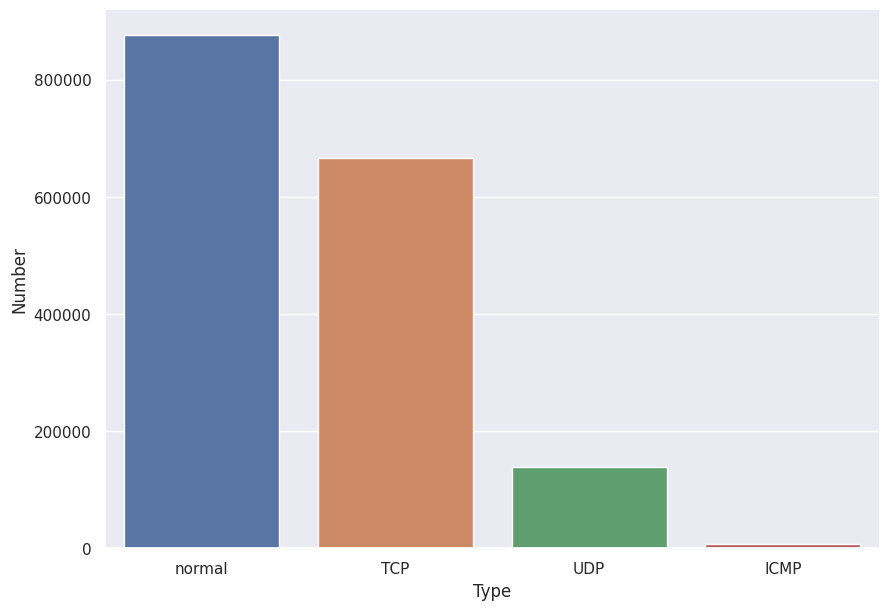

In [22]:
sns.set(rc = {'figure.figsize' : (10, 7)})
ax = sns.countplot(x = 'attackDescription', data = df)
ax.set(xlabel = 'Type', ylabel = 'Number')
plt.show()

### Other features

In [23]:
def convert_to_int(value):
    try:
        if 'M' in str(value):
            result = int(float(value[:-2])*10**6)
        else:
            result = int(value)
    except (ValueError, TypeError):
        print(value)
        result = 0
    return result

In [24]:
df['Bytes'] = df['Bytes'].apply(convert_to_int)
df['Bytes'].value_counts()

54       441451
66       269637
58       218650
42       110075
70        38081
          ...  
37744         1
15772         1
16351         1
9182          1
20573         1
Name: Bytes, Length: 28332, dtype: int64

In [25]:
label_encoder = LabelEncoder()
df['label']= label_encoder.fit_transform(df['label'])
label_encoder.classes_

array(['0_normal', 'attack'], dtype=object)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Duration           1689346 non-null  float64
 1   Proto              1689346 non-null  object 
 2   Src Pt             1689346 non-null  int64  
 3   Dst Pt             1689346 non-null  float64
 4   Packets            1689346 non-null  int64  
 5   Bytes              1689346 non-null  int64  
 6   Flows              1689346 non-null  int64  
 7   Flags              1689346 non-null  object 
 8   Tos                1689346 non-null  int64  
 9   label              1689346 non-null  int64  
 10  attackDescription  1689346 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 154.7+ MB


In [27]:
features_to_exclude = ['label', 'Proto']
y = df.loc[:, features_to_exclude]
X = df.drop(features_to_exclude, axis=1)

print(X.shape, y.shape)

(1689346, 9) (1689346, 2)


In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Duration           1689346 non-null  float64
 1   Src Pt             1689346 non-null  int64  
 2   Dst Pt             1689346 non-null  float64
 3   Packets            1689346 non-null  int64  
 4   Bytes              1689346 non-null  int64  
 5   Flows              1689346 non-null  int64  
 6   Flags              1689346 non-null  object 
 7   Tos                1689346 non-null  int64  
 8   attackDescription  1689346 non-null  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 128.9+ MB


In [29]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1689346 non-null  int64 
 1   Proto   1689346 non-null  object
dtypes: int64(1), object(1)
memory usage: 38.7+ MB


### One hot encoding

In [30]:
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689346 entries, 3 to 5231835
Data columns (total 32 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Duration                  1689346 non-null  float64
 1   Src Pt                    1689346 non-null  int64  
 2   Dst Pt                    1689346 non-null  float64
 3   Packets                   1689346 non-null  int64  
 4   Bytes                     1689346 non-null  int64  
 5   Flows                     1689346 non-null  int64  
 6   Tos                       1689346 non-null  int64  
 7   Flags_......              1689346 non-null  uint8  
 8   Flags_.....F              1689346 non-null  uint8  
 9   Flags_....S.              1689346 non-null  uint8  
 10  Flags_...R..              1689346 non-null  uint8  
 11  Flags_...RS.              1689346 non-null  uint8  
 12  Flags_.A....              1689346 non-null  uint8  
 13  Flags_.A...F              1

In [31]:
final_df = pd.concat([X, y], axis=1)
final_df

,Duration,Src Pt,Dst Pt,Packets,Bytes,Flows,Tos,Flags_......,Flags_.....F,Flags_....S.,Flags_...R..,Flags_...RS.,Flags_.A....,Flags_.A...F,Flags_.A..S.,Flags_.A..SF,Flags_.A.R..,Flags_.A.R.F,Flags_.A.RS.,Flags_.A.RSF,Flags_.AP...,Flags_.AP..F,Flags_.AP.S.,Flags_.AP.SF,Flags_.APR..,Flags_.APR.F,Flags_.APRS.,Flags_.APRSF,attackDescription_ICMP,attackDescription_TCP,attackDescription_UDP,attackDescription_normal,label,Proto
3,0.095,443,58538.0,5,1246,1,32,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
15,0.000,57315,443.0,1,66,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
18,0.021,60025,80.0,2,108,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
21,0.000,63957,53.0,1,82,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
26,0.032,40285,80.0,3,624,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231831,0.000,5907,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
5231832,0.000,3,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
5231833,0.000,32778,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
5231834,0.000,8800,47529.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP


### Train-Test split

In [32]:
train, test = train_test_split(final_df, test_size=0.3, random_state=42)
train

,Duration,Src Pt,Dst Pt,Packets,Bytes,Flows,Tos,Flags_......,Flags_.....F,Flags_....S.,Flags_...R..,Flags_...RS.,Flags_.A....,Flags_.A...F,Flags_.A..S.,Flags_.A..SF,Flags_.A.R..,Flags_.A.R.F,Flags_.A.RS.,Flags_.A.RSF,Flags_.AP...,Flags_.AP..F,Flags_.AP.S.,Flags_.AP.SF,Flags_.APR..,Flags_.APR.F,Flags_.APRS.,Flags_.APRSF,attackDescription_ICMP,attackDescription_TCP,attackDescription_UDP,attackDescription_normal,label,Proto
2229571,0.000,443,60382.0,1,66,1,32,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
3279170,0.000,80,55252.0,1,66,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
2212238,0.021,443,54397.0,3,193,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,TCP
4756011,0.000,787,50342.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
2265158,0.045,53,36795.0,2,380,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294916,0.026,62375,443.0,4,568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
4937499,6.410,0,3.3,5,350,1,192,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,ICMP
658411,0.000,53,57615.0,1,91,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
2931232,0.000,46755,4129.0,1,58,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP


In [33]:
# @title drop udp of train

train = train[(train['attackDescription_UDP'] != 1)]
train.shape

(1085286, 34)

In [34]:
train["Proto"].unique()

array(['TCP  ', 'UDP  ', 'ICMP ', 'IGMP '], dtype=object)

In [35]:
# @title drop udp protocol

train = train.loc[~((train["Proto"] == 'UDP  ') & (train["label"] == 1))]
train.shape

(1082042, 34)

In [36]:
train = train.reset_index(drop=True)
train

,Duration,Src Pt,Dst Pt,Packets,Bytes,Flows,Tos,Flags_......,Flags_.....F,Flags_....S.,Flags_...R..,Flags_...RS.,Flags_.A....,Flags_.A...F,Flags_.A..S.,Flags_.A..SF,Flags_.A.R..,Flags_.A.R.F,Flags_.A.RS.,Flags_.A.RSF,Flags_.AP...,Flags_.AP..F,Flags_.AP.S.,Flags_.AP.SF,Flags_.APR..,Flags_.APR.F,Flags_.APRS.,Flags_.APRSF,attackDescription_ICMP,attackDescription_TCP,attackDescription_UDP,attackDescription_normal,label,Proto
0,0.000,443,60382.0,1,66,1,32,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
1,0.000,80,55252.0,1,66,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
2,0.021,443,54397.0,3,193,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,TCP
3,0.000,787,50342.0,1,54,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP
4,0.045,53,36795.0,2,380,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082037,0.000,80,59642.0,1,66,1,32,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,TCP
1082038,0.026,62375,443.0,4,568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,TCP
1082039,0.000,53,57615.0,1,91,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,UDP
1082040,0.000,46755,4129.0,1,58,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,TCP


In [37]:
test = test.reset_index(drop=True)

In [38]:
train = train.drop("Proto", axis=1)
test = test.drop("Proto", axis=1)

# **MODEL**

## **STEP 1**

In [39]:
X_train = train.iloc[:, :-5]
X_test = test.iloc[:, :-5]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082042 entries, 0 to 1082041
Data columns (total 28 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Duration      1082042 non-null  float64
 1   Src Pt        1082042 non-null  int64  
 2   Dst Pt        1082042 non-null  float64
 3   Packets       1082042 non-null  int64  
 4   Bytes         1082042 non-null  int64  
 5   Flows         1082042 non-null  int64  
 6   Tos           1082042 non-null  int64  
 7   Flags_......  1082042 non-null  uint8  
 8   Flags_.....F  1082042 non-null  uint8  
 9   Flags_....S.  1082042 non-null  uint8  
 10  Flags_...R..  1082042 non-null  uint8  
 11  Flags_...RS.  1082042 non-null  uint8  
 12  Flags_.A....  1082042 non-null  uint8  
 13  Flags_.A...F  1082042 non-null  uint8  
 14  Flags_.A..S.  1082042 non-null  uint8  
 15  Flags_.A..SF  1082042 non-null  uint8  
 16  Flags_.A.R..  1082042 non-null  uint8  
 17  Flags_.A.R.F  1082042 non-n

### Round 1

In [40]:
#Detect tcp

from lightgbm import LGBMClassifier

model = LGBMClassifier()
clf_1 = model.fit(X_train, train['attackDescription_TCP'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 462523, number of negative: 619519
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 1082042, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427454 -> initscore=-0.292247
[LightGBM] [Info] Start training from score -0.292247


In [41]:
start_time = time.time()
y_pred_1 = clf_1.predict(X_test)
end_time = time.time()
execution_time_r1 = end_time - start_time

In [42]:
cm = confusion_matrix(test['attackDescription_TCP'], y_pred_1)

acc = accuracy_score(test['attackDescription_TCP'], y_pred_1)
ppv = precision_score(test['attackDescription_TCP'], y_pred_1, average='macro')
f1 = f1_score(test['attackDescription_TCP'], y_pred_1, average='macro')
tpr = recall_score(test['attackDescription_TCP'], y_pred_1, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(test['attackDescription_TCP'], y_pred_1)
mcc = matthews_corrcoef(test['attackDescription_TCP'], y_pred_1)
# udr = sum(y_pred_1[Service_Scan_test_index] == test['attackDescription_TCP'][Service_Scan_test_index]) / len(Service_Scan_test_index)

# model_pred['Tabnet'] = y_pred_1
# model_acc['Tabnet'] = acc
# model_ppv['Tabnet'] = ppv
# model_f1['Tabnet'] = f1
# model_tpr['Tabnet'] = tpr
# model_fpr['Tabnet'] = fpr
# model_auc['Tabnet'] = auc
# model_mcc['Tabnet'] = mcc
# model_udr['Tabnet'] = udr

print('Scores of round 1:')
# print(f'\tUDR: {udr} ({sum(y_pred_1[Service_Scan_test_index] == test['attackDescription_TCP'][Service_Scan_test_index])} / {len(Service_Scan_test_index)})')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of round 1:
	ACC: 0.9701975517162453
	PPV: 0.9655055079533574
	TPR: 0.973786117951466
	F1 : 0.9690988410534362
	AUC: 0.9737861179514659
	MCC: 0.9392551250820972
	FPR: 0.04321361773120361


In [43]:
print(confusion_matrix(test['attackDescription_TCP'], y_pred_1))

[[293632  13262]
 [  1842 198068]]


In [44]:
print(classification_report(test['attackDescription_TCP'], y_pred_1))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    306894
           1       0.94      0.99      0.96    199910

    accuracy                           0.97    506804
   macro avg       0.97      0.97      0.97    506804
weighted avg       0.97      0.97      0.97    506804



In [45]:
remain_indices_1 = test.index[np.where(y_pred_1 == 0)[0]]
print(remain_indices_1)

Int64Index([     0,      4,      5,      6,      7,      8,      9,     10,
                11,     12,
            ...
            506789, 506791, 506792, 506793, 506795, 506796, 506800, 506801,
            506802, 506803],
           dtype='int64', length=295474)


In [46]:
tcp_pred = test.index[np.where(y_pred_1 == 1)[0]]
print(tcp_pred)

Int64Index([     1,      2,      3,     14,     16,     17,     23,     25,
                27,     29,
            ...
            506780, 506782, 506783, 506785, 506787, 506790, 506794, 506797,
            506798, 506799],
           dtype='int64', length=211330)


### Round 2

In [47]:
#Detect icmp
model = LGBMClassifier()
clf_2 = model.fit(X_train, train['attackDescription_ICMP'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5543, number of negative: 1076499
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 1082042, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005123 -> initscore=-5.268934
[LightGBM] [Info] Start training from score -5.268934


In [48]:
X_test_2 = X_test.loc[remain_indices_1]
test_2 = test.loc[remain_indices_1]

In [49]:
start_time = time.time()
y_pred_2 = clf_2.predict(X_test_2)
end_time = time.time()
execution_time_r2 = end_time - start_time

In [50]:
cm = confusion_matrix(test_2['attackDescription_ICMP'], y_pred_2)

acc = accuracy_score(test_2['attackDescription_ICMP'], y_pred_2)
ppv = precision_score(test_2['attackDescription_ICMP'], y_pred_2, average='macro')
f1 = f1_score(test_2['attackDescription_ICMP'], y_pred_2, average='macro')
tpr = recall_score(test_2['attackDescription_ICMP'], y_pred_2, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(test_2['attackDescription_ICMP'], y_pred_2)
mcc = matthews_corrcoef(test_2['attackDescription_ICMP'], y_pred_2)

print('Scores of round 2:')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of round 2:
	ACC: 0.9988425377528988
	PPV: 0.8187538254518778
	TPR: 0.9099586349362643
	F1 : 0.8586209308357073
	AUC: 0.9099586349362643
	MCC: 0.7229823875115191
	FPR: 0.0008374471086036671


In [51]:
print(confusion_matrix(test_2['attackDescription_ICMP'], y_pred_2))

[[294697    247]
 [    95    435]]


In [52]:
print(classification_report(test_2['attackDescription_ICMP'], y_pred_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    294944
           1       0.64      0.82      0.72       530

    accuracy                           1.00    295474
   macro avg       0.82      0.91      0.86    295474
weighted avg       1.00      1.00      1.00    295474



In [53]:
remain_indices_2 = test_2.index[np.where(y_pred_2 == 0)[0]]
print(remain_indices_2)

Int64Index([     0,      4,      5,      6,      7,      8,      9,     10,
                11,     12,
            ...
            506788, 506789, 506791, 506792, 506793, 506795, 506796, 506800,
            506802, 506803],
           dtype='int64', length=294792)


In [54]:
icmp_pred = test_2.index[np.where(y_pred_2 == 1)[0]]
print(icmp_pred)

Int64Index([   211,   1745,   1950,   2247,   4461,   4826,   4967,   5126,
              5175,   5207,
            ...
            499588, 499686, 500453, 501840, 502537, 502810, 503390, 504611,
            505079, 506801],
           dtype='int64', length=682)


## **STEP 2**

## Outlier

In [55]:
%pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=3a3e21ccf9fb9b3539c058776862fe01c4ba89abb22f57b04747283bdf10ac01
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


### LOF

In [56]:
train_lof = train[(train['label'] == 0)]
X_train_lof = train_lof.iloc[:, :-5]

In [57]:
X_test_3 = X_test.loc[remain_indices_2]
test_3 = test.loc[remain_indices_2]

In [58]:
# # train an LOF detector
# from pyod.models.ecod import ECOD
# from pyod.models.abod import ABOD
# from pyod.models.alad import ALAD
# from pyod.models.anogan import AnoGAN
# from pyod.models.rod import ROD
# from pyod.models.lof import LOF
# from pyod.models.lscp import LSCP
# from pyod.models.ocsvm import OCSVM
# from pyod.models.cblof import CBLOF
# from pyod.models.knn import KNN
# from pyod.models.inne import INNE
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.iforest import IForest

# # model_1 = OCSVM()
# # model_2 = CBLOF()
# # model_3 = KNN()

# clf_lof = LOF( contamination=0.05)
# clf_lof.fit(X_train_lof)

# # get outlier scores
# y_train_scores = clf_lof.decision_scores_  # raw outlier scores on the train data
# y_test_scores = clf_lof.decision_function(X_test_3)  # predict raw outlier scores on test
# print(f"Train_score: {y_train_scores.mean()}")
# print(f"Test_score: {y_test_scores.mean()}")

In [59]:
from joblib import dump, load

# save the model
# dump(clf_lof, 'clf_lof_tcp_icmp.joblib')
# load the model
clf_lof = load('/content/drive/MyDrive/Colab Notebooks/data/CIDDS Data/clf_lof_tcp.joblib')

In [60]:
start_time = time.time()

y_pred_lof = clf_lof.predict(X_test_3)

end_time = time.time()
execution_time_lof = end_time - start_time

pd.DataFrame(y_pred_lof).value_counts()

0    252183
1     42609
dtype: int64

In [61]:
test_3['attackDescription_normal'].value_counts()

1    262117
0     32675
Name: attackDescription_normal, dtype: int64

In [62]:
true_abnormal_1 = test_3['attackDescription_normal'].copy()
true_abnormal_1 = true_abnormal_1.replace({0: 1, 1: 0})
true_abnormal_1.value_counts()

0    262117
1     32675
Name: attackDescription_normal, dtype: int64

In [63]:
cm = confusion_matrix(true_abnormal_1, y_pred_lof)

acc = accuracy_score(true_abnormal_1, y_pred_lof)
ppv = precision_score(true_abnormal_1, y_pred_lof, average='macro')
f1 = f1_score(true_abnormal_1, y_pred_lof, average='macro')
tpr = recall_score(true_abnormal_1, y_pred_lof, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(true_abnormal_1, y_pred_lof)
mcc = matthews_corrcoef(true_abnormal_1, y_pred_lof)

print('Scores of outlier:')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of outlier:
	ACC: 0.94551412521371
	PPV: 0.8413985849483314
	TPR: 0.928319730269678
	F1 : 0.8777085470830976
	AUC: 0.928319730269678
	MCC: 0.7647947432338145
	FPR: 0.04958854252108791


In [64]:
print(confusion_matrix(true_abnormal_1, y_pred_lof))

[[249119  12998]
 [  3064  29611]]


In [65]:
print(classification_report(true_abnormal_1, y_pred_lof))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    262117
           1       0.69      0.91      0.79     32675

    accuracy                           0.95    294792
   macro avg       0.84      0.93      0.88    294792
weighted avg       0.96      0.95      0.95    294792



In [66]:
remain_indices_3 = test_3.index[np.where(y_pred_lof == 0)[0]]
print(remain_indices_3)

Int64Index([     4,      5,      6,      7,      8,     11,     12,     13,
                18,     19,
            ...
            506781, 506784, 506786, 506788, 506789, 506792, 506793, 506795,
            506796, 506800],
           dtype='int64', length=252183)


In [67]:
udp_pred_lof = true_abnormal_1.index[np.where(y_pred_lof == 1)[0]]

### INNE

In [68]:
train_inne = train[(train['label'] == 0)]
X_train_inne = train_inne.iloc[:, :-5]

In [69]:
X_test_4 = X_test.loc[remain_indices_3]
test_4 = test.loc[remain_indices_3]

In [70]:
# # train with INNE detector
# from pyod.models.ecod import ECOD
# from pyod.models.abod import ABOD
# from pyod.models.alad import ALAD
# from pyod.models.anogan import AnoGAN
# from pyod.models.rod import ROD
# from pyod.models.lof import LOF
# from pyod.models.lscp import LSCP
# from pyod.models.ocsvm import OCSVM
# from pyod.models.cblof import CBLOF
# from pyod.models.knn import KNN
# from pyod.models.inne import INNE
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.iforest import IForest

# # model_1 = OCSVM()
# # model_2 = CBLOF()
# # model_3 = KNN()

# clf_inne = INNE( contamination=0.05)
# clf_inne.fit(X_train_inne)

# # get outlier scores
# y_train_scores = clf_inne.decision_scores_  # raw outlier scores on the train data
# y_test_scores = clf_inne.decision_function(X_test_4)  # predict raw outlier scores on test
# print(f"Train_score: {y_train_scores.mean()}")
# print(f"Test_score: {y_test_scores.mean()}")

In [71]:
from joblib import dump, load

# save the model
# dump(clf_inne, 'clf_inne_tcp_icmp.joblib')
# load the model
clf_inne = load('/content/drive/MyDrive/Colab Notebooks/data/CIDDS Data/clf_inne_tcp.joblib')

In [72]:
start_time = time.time()

y_pred_inne = clf_inne.predict(X_test_4)

end_time = time.time()
execution_time_inne = end_time - start_time

pd.DataFrame(y_pred_inne).value_counts()

0    237663
1     14520
dtype: int64

In [73]:
test_4['attackDescription_normal'].value_counts()

1    249119
0      3064
Name: attackDescription_normal, dtype: int64

In [74]:
true_abnormal_2 = test_4['attackDescription_normal'].copy()
true_abnormal_2 = true_abnormal_2.replace({0: 1, 1: 0})
true_abnormal_2.value_counts()


0    249119
1      3064
Name: attackDescription_normal, dtype: int64

In [75]:
cm = confusion_matrix(true_abnormal_2, y_pred_inne)

acc = accuracy_score(true_abnormal_2, y_pred_inne)
ppv = precision_score(true_abnormal_2, y_pred_inne, average='macro')
f1 = f1_score(true_abnormal_2, y_pred_inne, average='macro')
tpr = recall_score(true_abnormal_2, y_pred_inne, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(true_abnormal_2, y_pred_inne)
mcc = matthews_corrcoef(true_abnormal_2, y_pred_inne)

print('Scores of outlier:')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of outlier:
	ACC: 0.9455871331533053
	PPV: 0.5641108631212409
	TPR: 0.7898439250047717
	F1 : 0.5957211366060808
	AUC: 0.7898439250047716
	MCC: 0.2726326774435091
	FPR: 0.05053408210533922


In [76]:
print(confusion_matrix(true_abnormal_2, y_pred_inne))

[[236530  12589]
 [  1133   1931]]


In [77]:
print(classification_report(true_abnormal_2, y_pred_inne))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    249119
           1       0.13      0.63      0.22      3064

    accuracy                           0.95    252183
   macro avg       0.56      0.79      0.60    252183
weighted avg       0.98      0.95      0.96    252183



In [78]:
udp_pred_inne = true_abnormal_2.index[np.where(y_pred_inne == 1)[0]]
print(udp_pred_inne)

Int64Index([    26,     31,     33,     64,    257,    265,    299,    324,
               370,    427,
            ...
            506358, 506410, 506571, 506580, 506674, 506684, 506724, 506730,
            506775, 506784],
           dtype='int64', length=14520)


In [79]:
udp_pred = udp_pred_lof.append(udp_pred_inne)
udp_pred

Int64Index([     0,      9,     10,     15,     38,     44,     48,     60,
                77,    209,
            ...
            506358, 506410, 506571, 506580, 506674, 506684, 506724, 506730,
            506775, 506784],
           dtype='int64', length=57129)

# **RESULT**

### Binary

In [80]:
y_pred = np.zeros_like(y_pred_1)

In [81]:
y_pred[udp_pred]=1
y_pred[tcp_pred]=1
y_pred[icmp_pred]=1

pd.DataFrame(y_pred).value_counts()

1    269141
0    237663
dtype: int64

In [82]:
test_series = pd.Series(test['attackDescription_UDP'])
test_series

0         1
1         0
2         0
3         0
4         0
         ..
506799    0
506800    0
506801    1
506802    1
506803    0
Name: attackDescription_UDP, Length: 506804, dtype: uint8

In [83]:
udp_indices = np.where(test_series == 1)[0]

In [84]:
cm = confusion_matrix(test['label'], y_pred)

acc = accuracy_score(test['label'], y_pred)
ppv = precision_score(test['label'], y_pred, average='macro')
f1 = f1_score(test['label'], y_pred, average='macro')
tpr = recall_score(test['label'], y_pred, average='macro')
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
auc = roc_auc_score(test['label'], y_pred)
mcc = matthews_corrcoef(test['label'], y_pred)

num_detec = sum(y_pred[udp_indices] == 1)
num_UDP = sum(test['attackDescription_UDP'])
udr = num_detec / num_UDP

# model_pred['Tabnet'] = y_pred
# model_acc['Tabnet'] = acc
# model_ppv['Tabnet'] = ppv
# model_f1['Tabnet'] = f1
# model_tpr['Tabnet'] = tpr
# model_fpr['Tabnet'] = fpr
# model_auc['Tabnet'] = auc
# model_mcc['Tabnet'] = mcc
# model_udr['Tabnet'] = udr

print('Scores of hybrid_model:')
print(f'\tUDR: {udr} ({num_detec} / {num_UDP})')
print(f'\tACC: {acc}')
print(f'\tPPV: {ppv}')
print(f'\tTPR: {tpr}')
print(f'\tF1 : {f1}')
print(f'\tAUC: {auc}')
print(f'\tMCC: {mcc}')
print(f'\tFPR: {fpr}')

Scores of hybrid_model:
	UDR: 0.9850465509441151 (41369 / 41997)
	ACC: 0.9469499056834595
	PPV: 0.9497712060430388
	TPR: 0.9485848652545348
	F1 : 0.9469401387601403
	AUC: 0.9485848652545348
	MCC: 0.8983552879750553
	FPR: 0.09816025775456122


In [85]:
print(confusion_matrix(test['label'], y_pred))

[[236521  25744]
 [  1142 243397]]


In [86]:
print(classification_report(test['label'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    262265
           1       0.90      1.00      0.95    244539

    accuracy                           0.95    506804
   macro avg       0.95      0.95      0.95    506804
weighted avg       0.95      0.95      0.95    506804



### Multiclass

In [87]:
y_pred_multi = np.zeros_like(y_pred_1)

In [88]:
y_pred_multi[udp_pred]=1
y_pred_multi[tcp_pred]=2
y_pred_multi[icmp_pred]=3

pd.DataFrame(y_pred_multi).value_counts()

0    237663
2    211330
1     57129
3       682
dtype: int64

In [89]:
label_multi = test['label'].copy()
label_multi[test['attackDescription_TCP'] == 1] = 2
label_multi[test['attackDescription_ICMP'] == 1] = 3

In [90]:
print(confusion_matrix(label_multi, y_pred_multi))

[[236521  25367    366     11]
 [   637  30335  11033    231]
 [   459   1378 198068      5]
 [    46     49   1863    435]]


In [91]:
print(classification_report(label_multi, y_pred_multi))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    262265
           1       0.53      0.72      0.61     42236
           2       0.94      0.99      0.96    199910
           3       0.64      0.18      0.28      2393

    accuracy                           0.92    506804
   macro avg       0.78      0.70      0.70    506804
weighted avg       0.93      0.92      0.92    506804



### Time

In [92]:
print(f'{len(X_test)/(execution_time_r1)} ({len(X_test)} / {execution_time_r1})')

297049.5360287266 (506804 / 1.7061262130737305)


In [93]:
print(f'{len(X_test_2)/(execution_time_r2)} ({len(X_test_2)} / {execution_time_r2})')

336422.3057734624 (295474 / 0.8782830238342285)


In [94]:
print(f'{len(X_test_3)/(execution_time_lof)} ({len(X_test_3)} / {execution_time_lof})')

432.00346841221716 (294792 / 682.3834102153778)


In [95]:
print(f'{len(X_test_4)/(execution_time_inne)} ({len(X_test_4)} / {execution_time_inne})')

14316.716412691076 (252183 / 17.614583730697632)


In [96]:
total_time = execution_time_r1 + execution_time_r2 + execution_time_lof + execution_time_inne

In [97]:
#print(f'{len(test)/(total_time)} ({len(test)} / {total_time})')